<a href="https://colab.research.google.com/github/john-d-noble/callcenter/blob/main/CB_Step_4_Machine_Learning_Models_(Simplified).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install statsmodels
!pip uninstall -y numpy
!pip install numpy==1.26.4
!pip install pmdarima

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 66.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 22.0 MB/s eta 0:00:00


In [5]:
# ============================================================
# CELL 1: SETUP AND DATA SPLITTING (WITH BASIC FEATURE ENGINEERING, DROP MARKET, OUTLIER CAP)
# ============================================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

!pip install holidays

# Imports for basic features
import holidays
from datetime import date

# Load the base data
df = pd.read_csv('enhanced_eda_data.csv', index_col='Date', parse_dates=True)
target = 'calls'

# New: Cap outliers globally (1-99 percentile to reduce skew)
lower = df[target].quantile(0.01)
upper = df[target].quantile(0.99)
df[target] = np.clip(df[target], lower, upper)
print("Outliers capped in calls.")

# Use TimeSeriesSplit to create a final hold-out set (the last 20% of the data)
print("Splitting data into training/validation and a final hold-out test set...")
tscv_split = TimeSeriesSplit(n_splits=5)
all_splits = list(tscv_split.split(df))
train_val_idx, test_idx = all_splits[-1]

df_train_val = df.iloc[train_val_idx]
df_test = df.iloc[test_idx]

print(f"Training/Validation set size: {len(df_train_val)} records")
print(f"Hold-out test set size: {len(df_test)} records")

# Simplified feature engineering function
def add_basic_time_features(df, target_col='calls'):
    df = df.copy()

    # 1. Basic Trend (simple index)
    df['time_index'] = np.arange(len(df))
    df['trend_simple'] = df['time_index']

    # 2. Basic Holidays (binary only)
    min_year = df.index.min().year
    max_year = df.index.max().year
    us_holidays = holidays.US(years=range(min_year, max_year + 1))
    holiday_dates = list(us_holidays.keys())
    df['is_holiday'] = df.index.map(lambda x: 1 if x.date() in holiday_dates else 0)

    # 3. Minimal Lags/Rollings (weekly only)
    df[f'{target_col}_lag_7'] = df[target_col].shift(7)
    df[f'{target_col}_roll_mean_7'] = df[target_col].rolling(7).mean().shift(1)

    # Drop NaNs (or fill if too many drops)
    df = df.dropna().fillna(0)  # Simplified handling

    return df

# Apply separately
print("Adding basic time features...")
df_train_val = add_basic_time_features(df_train_val)
df_test = add_basic_time_features(df_test)

# Update splits, dropping market features
exclude_market = ['^VIX_close', 'SPY_close', 'SPY_volume', 'QQQ_close', 'QQQ_volume', 'DX-Y.NYB_close', 'GC=F_close', 'GC=F_volume', 'BTC-USD_close', 'BTC-USD_volume', 'ETH-USD_close', 'ETH-USD_volume']  # Financial columns
features = [col for col in df_train_val.columns if col != target and col not in exclude_market]
X_train_val = df_train_val[features]
y_train_val = df_train_val[target]
X_test = df_test[features]
y_test = df_test[target]

print("Market features dropped; basic features added and data prepared.")

Outliers capped in calls.
Splitting data into training/validation and a final hold-out test set...
Training/Validation set size: 815 records
Hold-out test set size: 163 records
Adding basic time features...
Market features dropped; basic features added and data prepared.


In [6]:
# ============================================================
# CELL 2: VERIFY DATA LOADING AND FEATURE FILTERING
# ============================================================

print("Data loaded and basic features added successfully.")

# Show full DataFrame head (includes all columns, including market for reference)
print("\nFull df_train_val head (market columns present here, but filtered out for modeling):")
display(df_train_val.head())

# Verify filtered features (market excluded)
print("\nFiltered features for modeling (market columns excluded):")
print(features)

# Show X_train_val head (should exclude market columns)
print("\nX_train_val head (filtered, no market columns):")
display(X_train_val.head())

Data loaded and basic features added successfully.

Full df_train_val head (market columns present here, but filtered out for modeling):


,calls,^VIX_close,SPY_close,SPY_volume,QQQ_close,QQQ_volume,DX-Y.NYB_close,GC=F_close,GC=F_volume,BTC-USD_close,...,Month,Quarter,DayOfWeek,Year,outlier_multivariate,time_index,trend_simple,is_holiday,calls_lag_7,calls_roll_mean_7
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-08,4410.0,21.129999,375.187500,104189600.0,264.686096,54659700.0,103.879997,1864.199951,26.0,17091.144531,...,1,1,6,2023,False,7,7,0,3874.93,5965.847143
2023-01-09,7166.0,21.969999,374.974762,73978100.0,266.399445,45568700.0,103.000000,1872.699951,62.0,17196.554688,...,1,1,0,2023,False,8,8,0,5055.00,6042.285714
2023-01-10,7381.0,20.580000,377.604370,65358100.0,268.654419,35247800.0,103.239998,1871.599976,101.0,17446.292969,...,1,1,1,2023,False,9,9,0,6537.00,6343.857143
2023-01-11,7215.0,21.090000,382.380341,68881100.0,273.302185,44077000.0,103.190002,1874.599976,1236.0,17934.896484,...,1,1,2,2023,False,10,10,0,7238.00,6464.428571
2023-01-12,7652.0,18.830000,383.772461,90157700.0,274.779144,60600000.0,102.250000,1895.500000,59.0,18869.587891,...,1,1,3,2023,False,11,11,0,7302.00,6461.142857



Filtered features for modeling (market columns excluded):
['is_weekend', 'Month', 'Quarter', 'DayOfWeek', 'Year', 'outlier_multivariate', 'time_index', 'trend_simple', 'is_holiday', 'calls_lag_7', 'calls_roll_mean_7']

X_train_val head (filtered, no market columns):


,is_weekend,Month,Quarter,DayOfWeek,Year,outlier_multivariate,time_index,trend_simple,is_holiday,calls_lag_7,calls_roll_mean_7
Date,,,,,,,,,,,
2023-01-08,True,1,1,6,2023,False,7,7,0,3874.93,5965.847143
2023-01-09,False,1,1,0,2023,False,8,8,0,5055.00,6042.285714
2023-01-10,False,1,1,1,2023,False,9,9,0,6537.00,6343.857143
2023-01-11,False,1,1,2,2023,False,10,10,0,7238.00,6464.428571
2023-01-12,False,1,1,3,2023,False,11,11,0,7302.00,6461.142857


In [7]:
# ============================================================
# CELL: DEFINE DISPLAY_CHAMPION_REPORT FUNCTION (WITH LOGGING AND NAN FIX)
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

def display_champion_report(y_true, y_pred, champion_name, model_object=None, X_features=None):
    """
    Displays a comprehensive set of visualizations and statistical metrics
    for a champion model directly in the notebook.
    """

    # Ensure inputs are pandas Series for easier handling
    y_true = pd.Series(y_true).squeeze()
    y_pred = pd.Series(y_pred, index=y_true.index).squeeze()
    residuals = y_true - y_pred

    # Clean residuals for tests (handle inf/nan, ensure enough points)
    residuals = residuals.replace([np.inf, -np.inf], np.nan).dropna()

    # Align y_true and y_pred to the cleaned residuals' index to match sizes
    y_true = y_true.loc[residuals.index]
    y_pred = y_pred.loc[residuals.index]

    if len(residuals) < 3:
        print("Too few valid residuals for statistical tests—skipping.")
        shapiro_p = np.nan
        lb_pvalue = np.nan
    else:
        shapiro_stat, shapiro_p = stats.shapiro(residuals)
        lb_test = acorr_ljungbox(residuals, lags=[min(10, len(residuals)-2)], return_df=True)
        lb_pvalue = lb_test['lb_pvalue'].iloc[0] if not lb_test.empty else np.nan

    # Set plot style
    plt.style.use('seaborn-v0_8-darkgrid')

    print("="*70)
    print(f"ð��� CHAMPION MODEL REPORT: {champion_name}")
    print("="*70)

    # --- Create Visualization Suite ---
    fig, axes = plt.subplots(4, 2, figsize=(20, 24))
    fig.suptitle(f'Champion Model "{champion_name}" Performance on Unseen Data', fontsize=20, fontweight='bold')

    # 1. Actual vs. Predicted Time Series
    axes[0, 0].plot(y_true.index, y_true, label='Actual', color='dodgerblue', alpha=0.9)
    axes[0, 0].plot(y_pred.index, y_pred, label='Predicted', color='red', linestyle='--')
    axes[0, 0].set_title('Actual vs. Predicted Over Time', fontweight='bold')
    axes[0, 0].set_ylabel('Calls')
    axes[0, 0].legend()
    axes[0, 0].grid(True, linestyle='--', alpha=0.6)

    # 2. Scatter Plot of Actual vs. Predicted
    axes[0, 1].scatter(y_true, y_pred, alpha=0.6, edgecolors='k')
    axes[0, 1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[0, 1].set_title('Actual vs. Predicted Scatter', fontweight='bold')
    axes[0, 1].set_xlabel('Actual Calls')
    axes[0, 1].set_ylabel('Predicted Calls')
    axes[0, 1].grid(True, linestyle='--', alpha=0.6)

    # 3. Residuals Over Time
    axes[1, 0].plot(residuals.index, residuals, color='purple')
    axes[1, 0].axhline(0, color='red', linestyle='--')
    axes[1, 0].set_title('Residuals Over Time', fontweight='bold')
    axes[1, 0].set_ylabel('Error (Actual - Predicted)')
    axes[1, 0].grid(True, linestyle='--', alpha=0.6)

    # 4. Residuals vs. Predicted Values
    axes[1, 1].scatter(y_pred, residuals, alpha=0.6, edgecolors='k')
    axes[1, 1].axhline(0, color='red', linestyle='--')
    axes[1, 1].set_title('Residuals vs. Predicted Values', fontweight='bold')
    axes[1, 1].set_xlabel('Predicted Calls')
    axes[1, 1].set_ylabel('Error')
    axes[1, 1].grid(True, linestyle='--', alpha=0.6)

    # 5. Residual Distribution (Histogram)
    sns.histplot(residuals, kde=True, ax=axes[2, 0], color='green')
    axes[2, 0].set_title('Distribution of Residuals', fontweight='bold')
    axes[2, 0].set_xlabel('Error')

    # 6. QQ-Plot for Normality Check
    stats.probplot(residuals, dist="norm", plot=axes[2, 1])
    axes[2, 1].set_title('QQ-Plot of Residuals', fontweight='bold')

    # 7. ACF of Residuals
    plot_acf(residuals, ax=axes[3, 0], lags=min(30, len(residuals)-1))
    axes[3, 0].set_title('Autocorrelation (ACF) of Residuals', fontweight='bold')

    # 8. PACF of Residuals
    plot_pacf(residuals, ax=axes[3, 1], lags=min(30, (len(residuals)//2)-1))
    axes[3, 1].set_title('Partial Autocorrelation (PACF) of Residuals', fontweight='bold')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # --- Statistical Summary ---
    print("\n" + "="*70)
    print("STATISTICAL SUMMARY ON HOLDOUT DATA")
    print("="*70 + "\n")

    # Performance Metrics (use aligned y_true/y_pred)
    mae = np.mean(np.abs(residuals))
    rmse = sqrt(np.mean(residuals**2))
    mape = np.mean(np.abs(residuals / y_true.replace(0, 1))) * 100 # Avoid division by zero
    r2 = 1 - (np.sum(residuals**2) / np.sum((y_true - y_true.mean())**2))

    print("ð��� OVERALL PERFORMANCE METRICS:")
    print(f"   MAE:  {mae:.2f}")
    print(f"   RMSE: {rmse:.2f}")
    print(f"   MAPE: {mape:.2f}%")
    print(f"   RÂ²:   {r2:.3f}\n")

    # Residual Diagnostics (using cleaned residuals)
    print("ð��� RESIDUAL ANALYSIS:")
    print(f"   Mean of Residuals:   {residuals.mean():.2f} (ideally close to 0)")
    print(f"   Std Dev of Residuals: {residuals.std():.2f}\n")
    shapiro_format = f"{shapiro_p:.4f}" if not np.isnan(shapiro_p) else 'nan'
    print(f"   Shapiro-Wilk Test (Normality): p-value = {shapiro_format}")
    print(f"   {'â�� Residuals appear normal' if shapiro_p > 0.05 else 'â�� Residuals do NOT appear normal'}\n")
    lb_format = f"{lb_pvalue:.4f}" if not np.isnan(lb_pvalue) else 'nan'
    print(f"   Ljung-Box Test (Autocorrelation): p-value = {lb_format}")
    print(f"   {'â�� Residuals appear independent' if (lb_pvalue > 0.05 if not np.isnan(lb_pvalue) else False) else 'â�� Residuals show significant autocorrelation'}")
    print("\n" + "="*70)

    # Log report for tracking
    with open('champion_report.txt', 'a') as f:
        f.write(f"\nChampion: {champion_name}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nMAPE: {mape:.2f}%\nR²: {r2:.3f}\nShapiro p: {shapiro_format}\nLjung-Box p: {lb_format}\n")
    print("Report logged to 'champion_report.txt'.")

Training refined simple models...

Naive baseline ready.
ð��� CHAMPION MODEL REPORT: Naive Weekly Mean


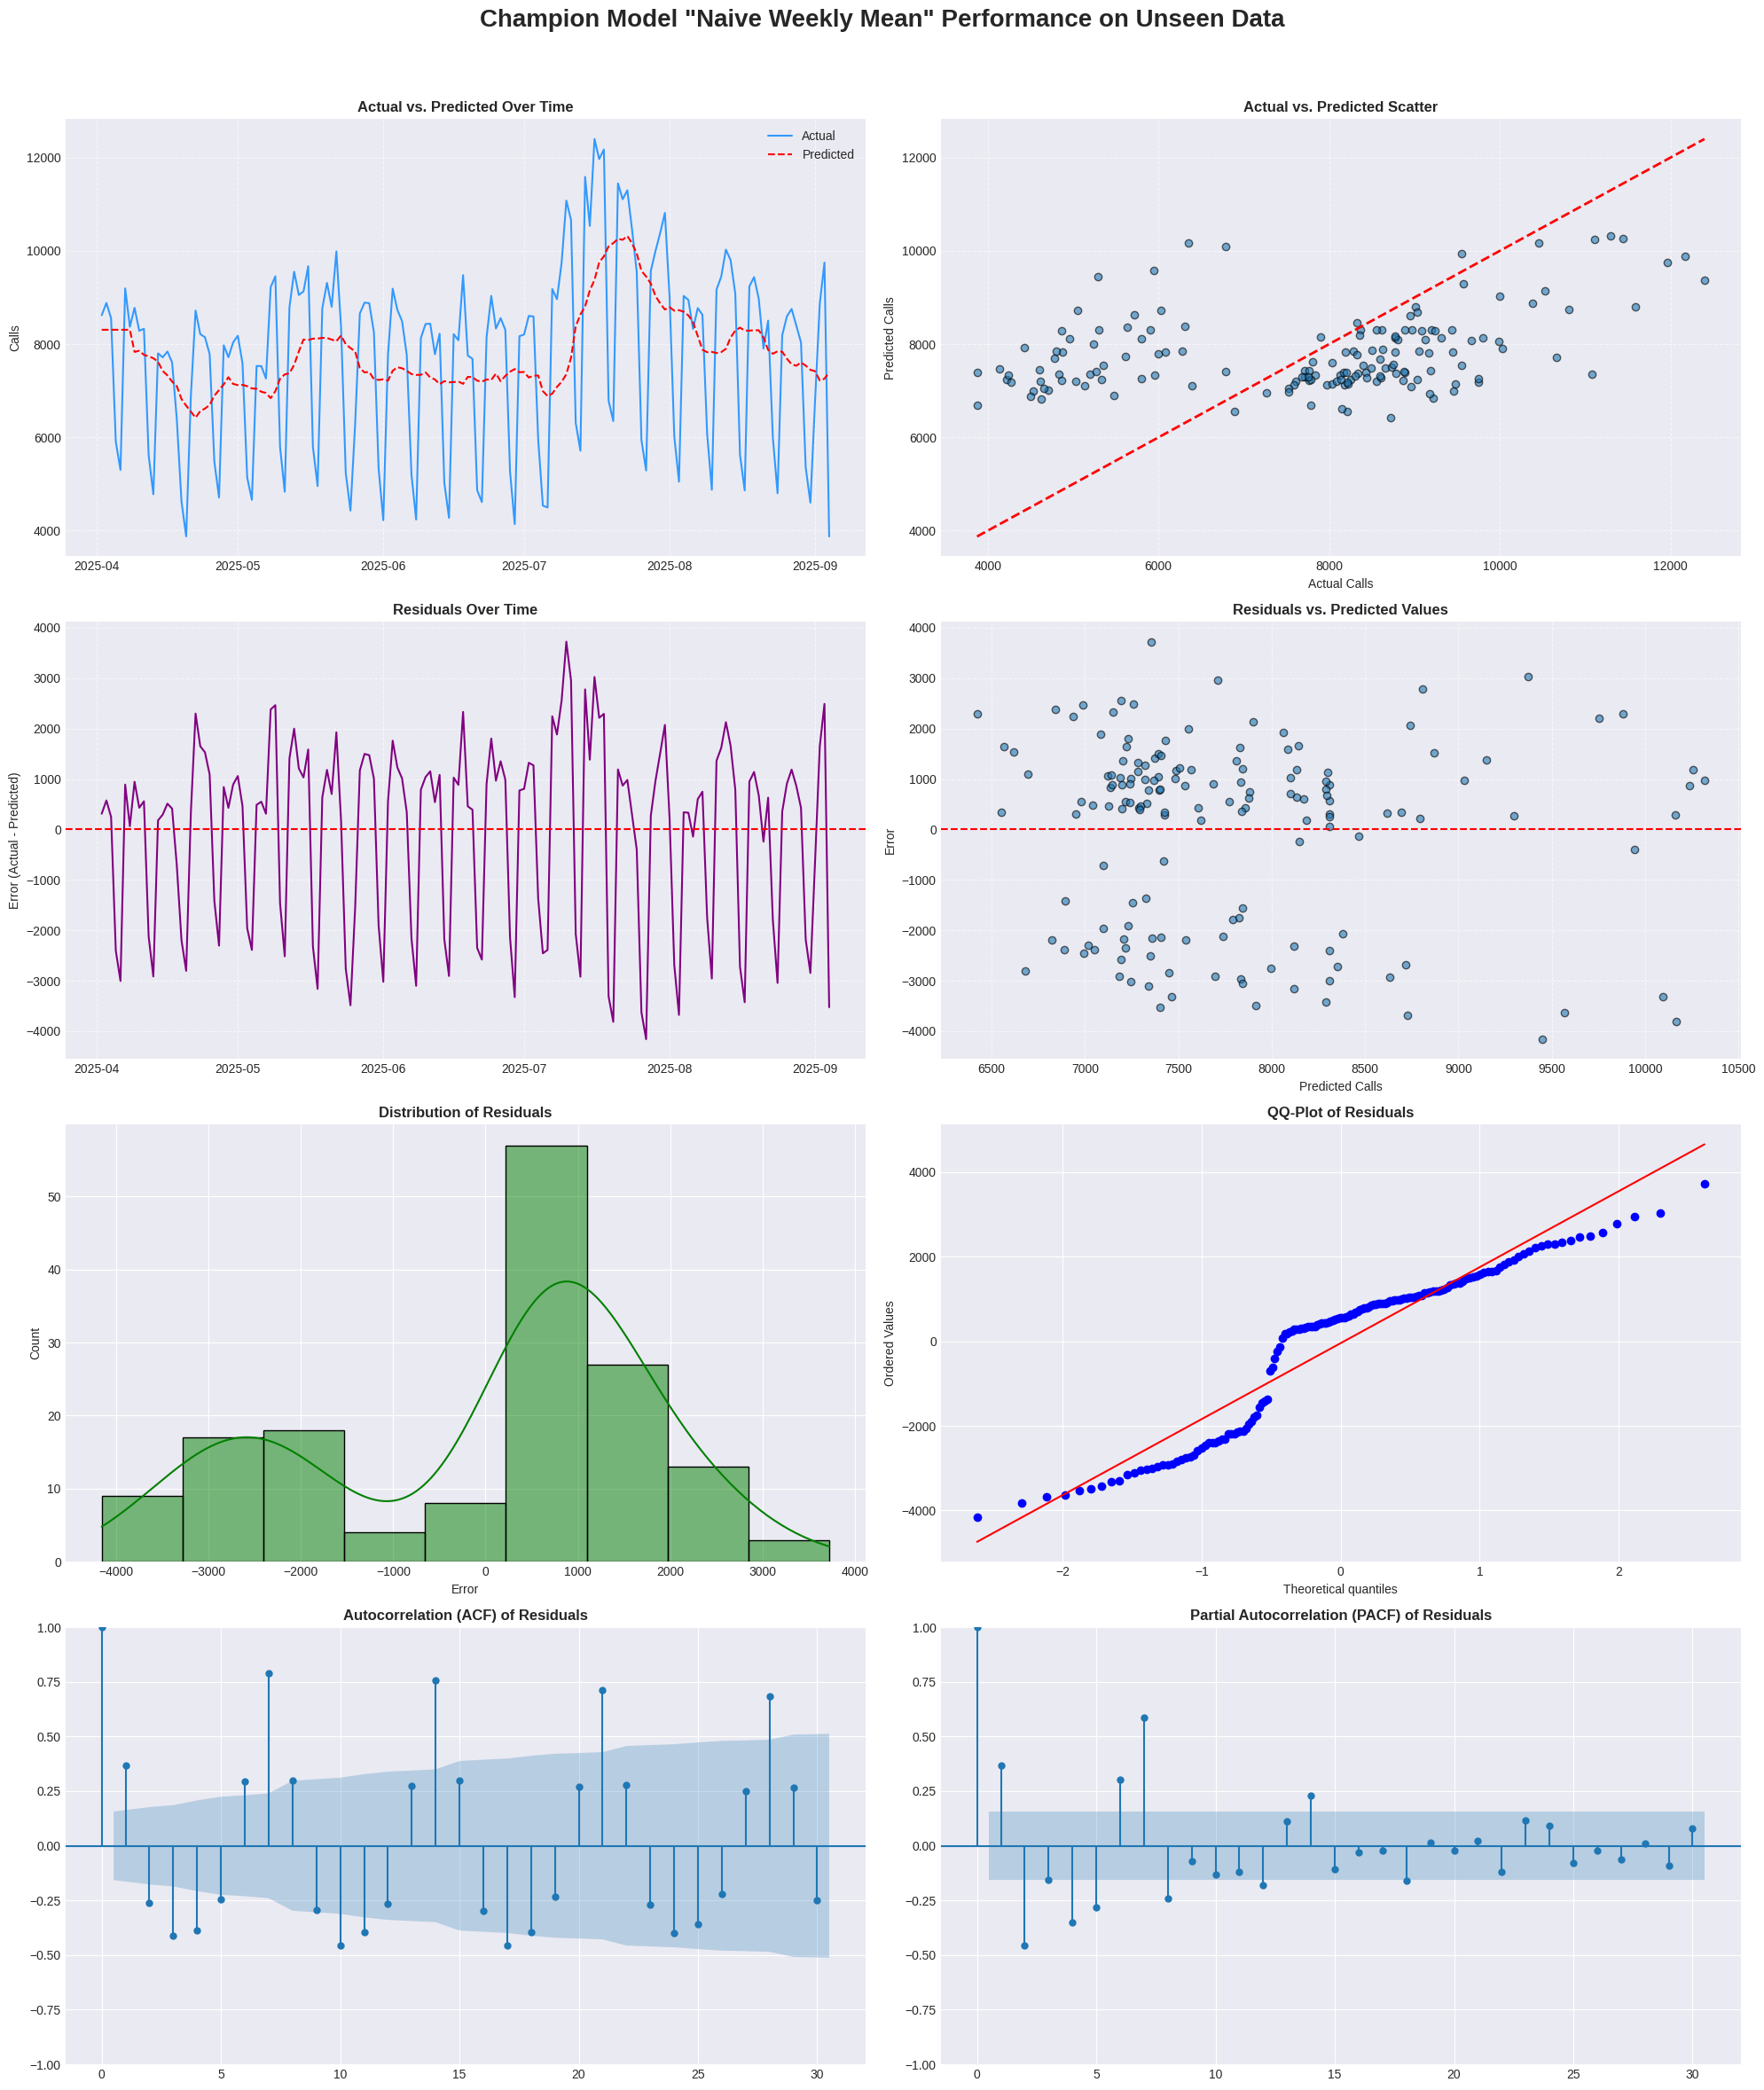


STATISTICAL SUMMARY ON HOLDOUT DATA

ð��� OVERALL PERFORMANCE METRICS:
   MAE:  1560.74
   RMSE: 1852.27
   MAPE: 24.09%
   RÂ²:   0.122

ð��� RESIDUAL ANALYSIS:
   Mean of Residuals:   -45.36 (ideally close to 0)
   Std Dev of Residuals: 1857.68

   Shapiro-Wilk Test (Normality): p-value = 0.0000
   â�� Residuals do NOT appear normal

   Ljung-Box Test (Autocorrelation): p-value = 0.0000
   â�� Residuals show significant autocorrelation

Report logged to 'champion_report.txt'.

Training Refined Simple SARIMA...
Refined Simple SARIMA trained.
ð��� CHAMPION MODEL REPORT: Refined Simple SARIMA (Log)


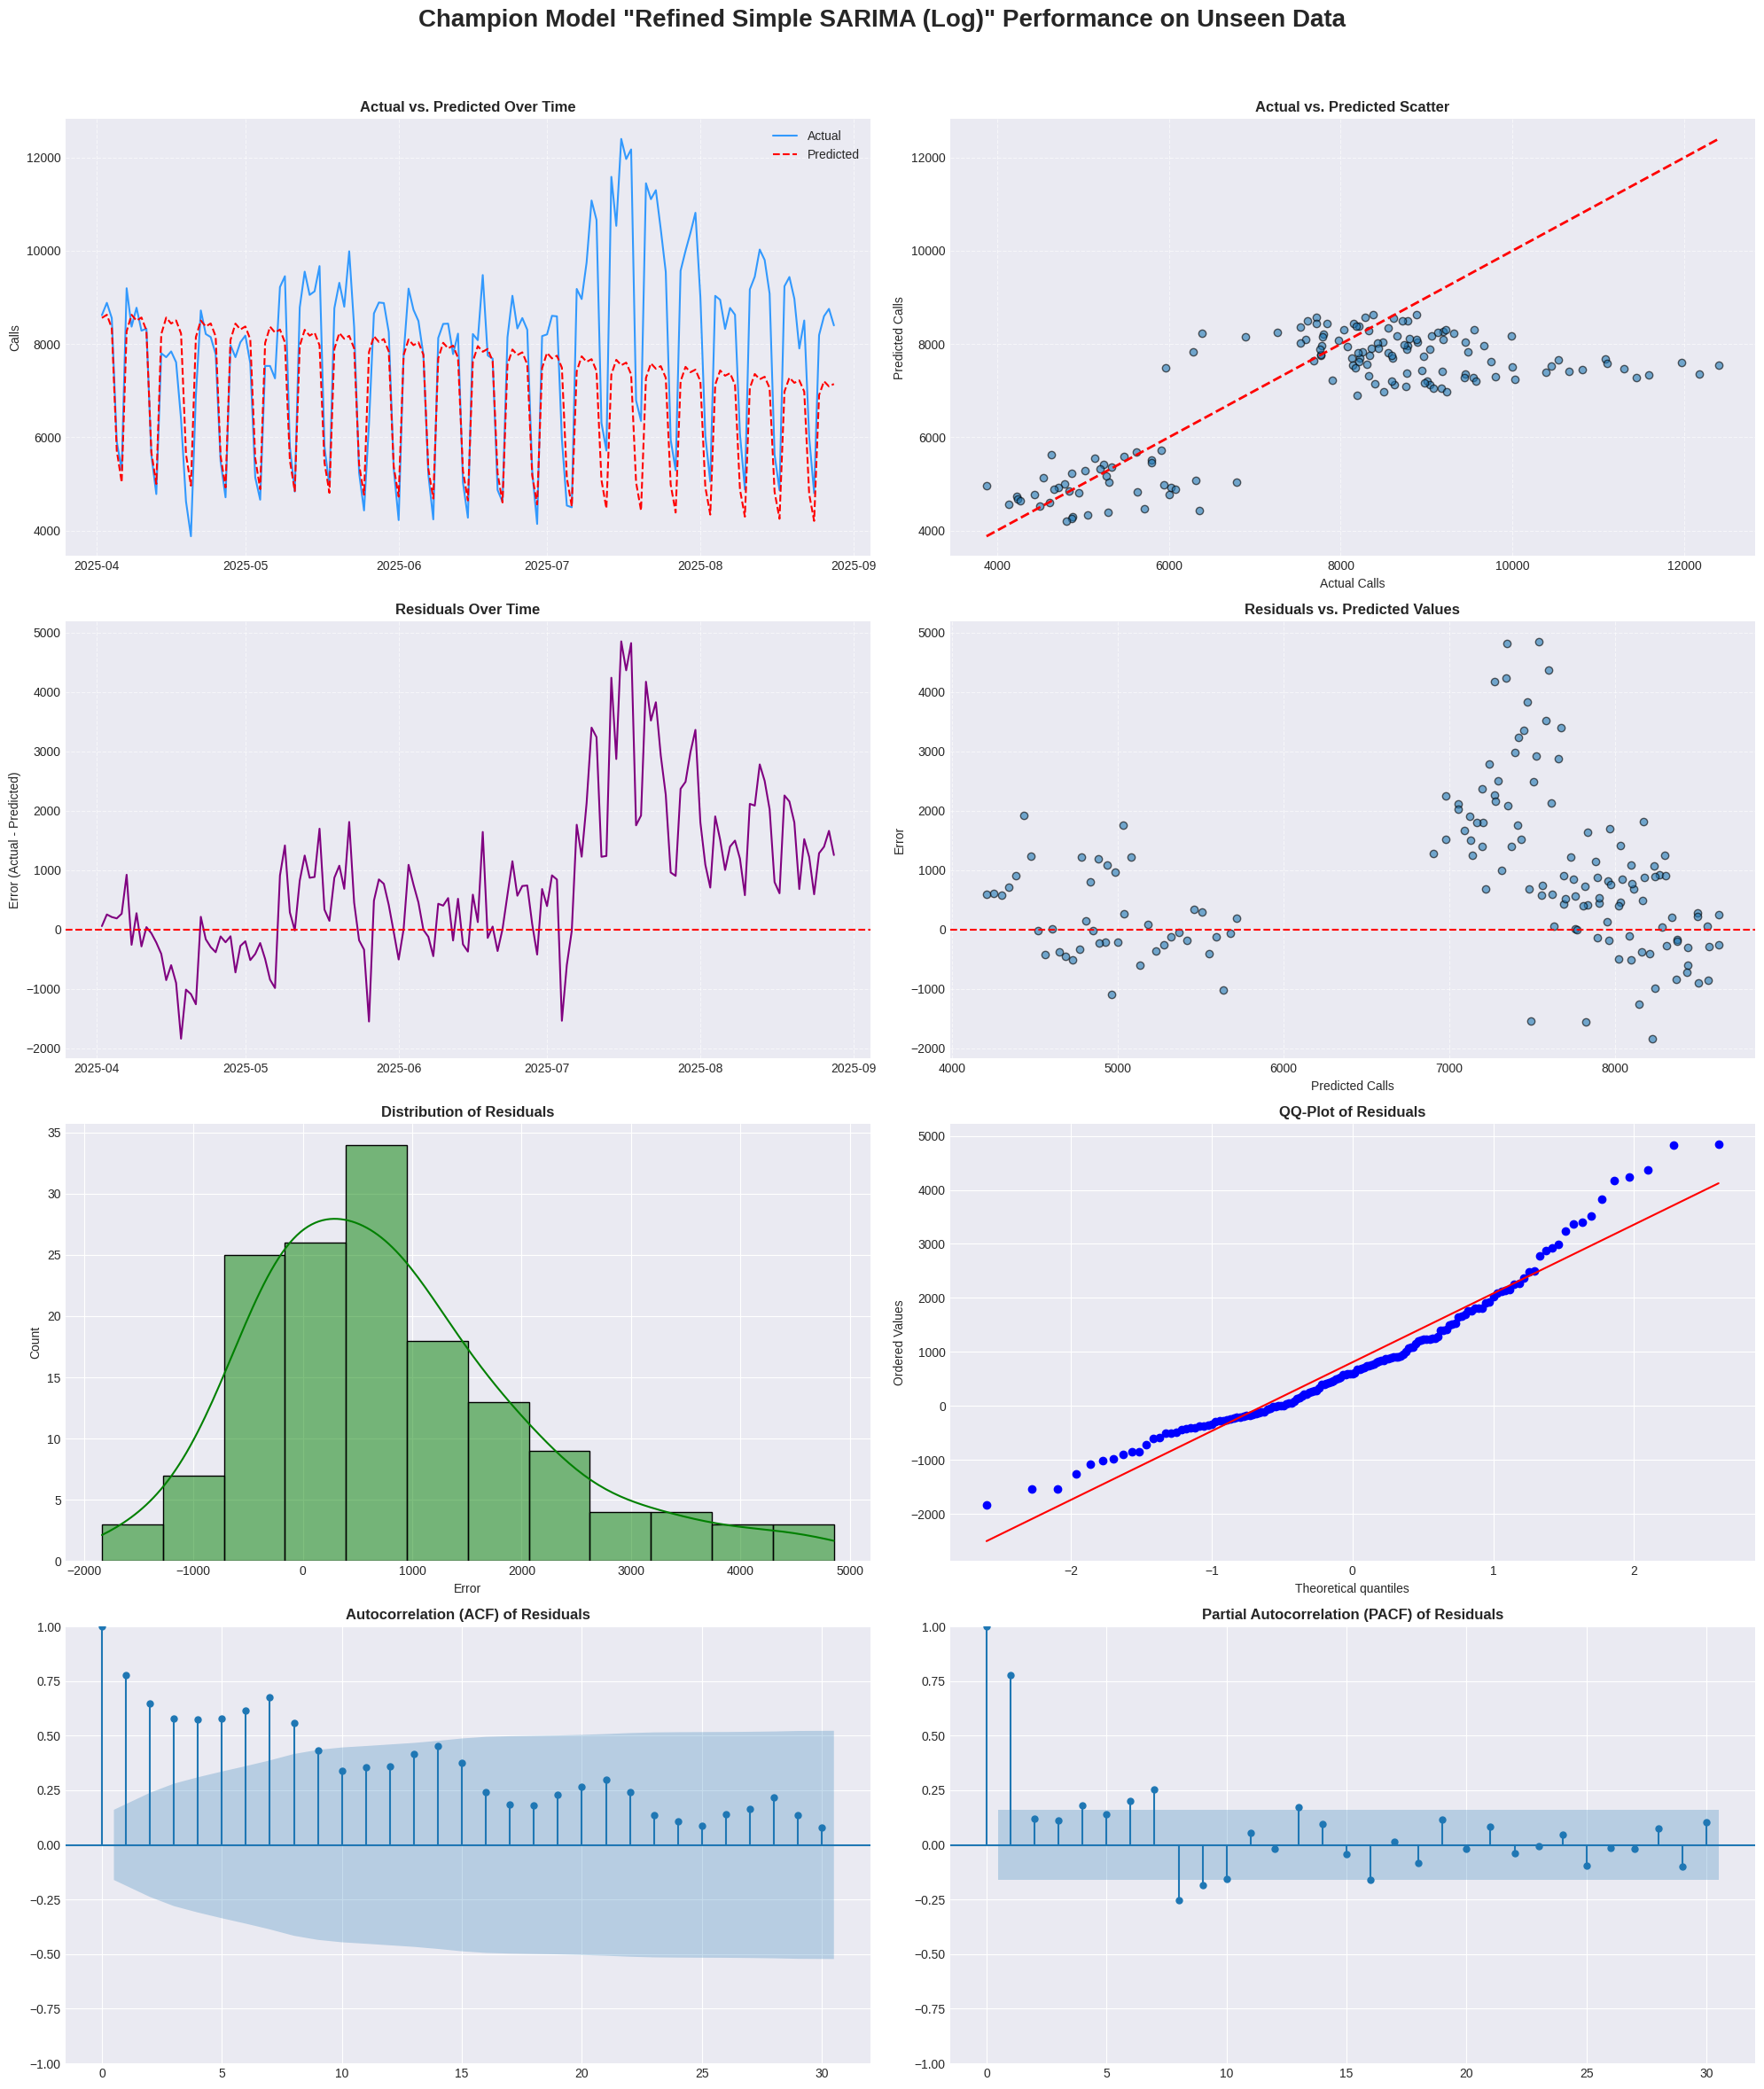

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps86cfm9y/icwk4isw.json



STATISTICAL SUMMARY ON HOLDOUT DATA

ð��� OVERALL PERFORMANCE METRICS:
   MAE:  1100.41
   RMSE: 1522.73
   MAPE: 12.94%
   RÂ²:   0.396

ð��� RESIDUAL ANALYSIS:
   Mean of Residuals:   808.73 (ideally close to 0)
   Std Dev of Residuals: 1294.56

   Shapiro-Wilk Test (Normality): p-value = 0.0000
   â�� Residuals do NOT appear normal

   Ljung-Box Test (Autocorrelation): p-value = 0.0000
   â�� Residuals show significant autocorrelation

Report logged to 'champion_report.txt'.

Training Prophet...


DEBUG:cmdstanpy:input tempfile: /tmp/tmps86cfm9y/kkaw1b7q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5560', 'data', 'file=/tmp/tmps86cfm9y/icwk4isw.json', 'init=/tmp/tmps86cfm9y/kkaw1b7q.json', 'output', 'file=/tmp/tmps86cfm9y/prophet_modeln36xkefu/prophet_model-20250919052747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:27:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:27:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet trained.
ð��� CHAMPION MODEL REPORT: Prophet Simple


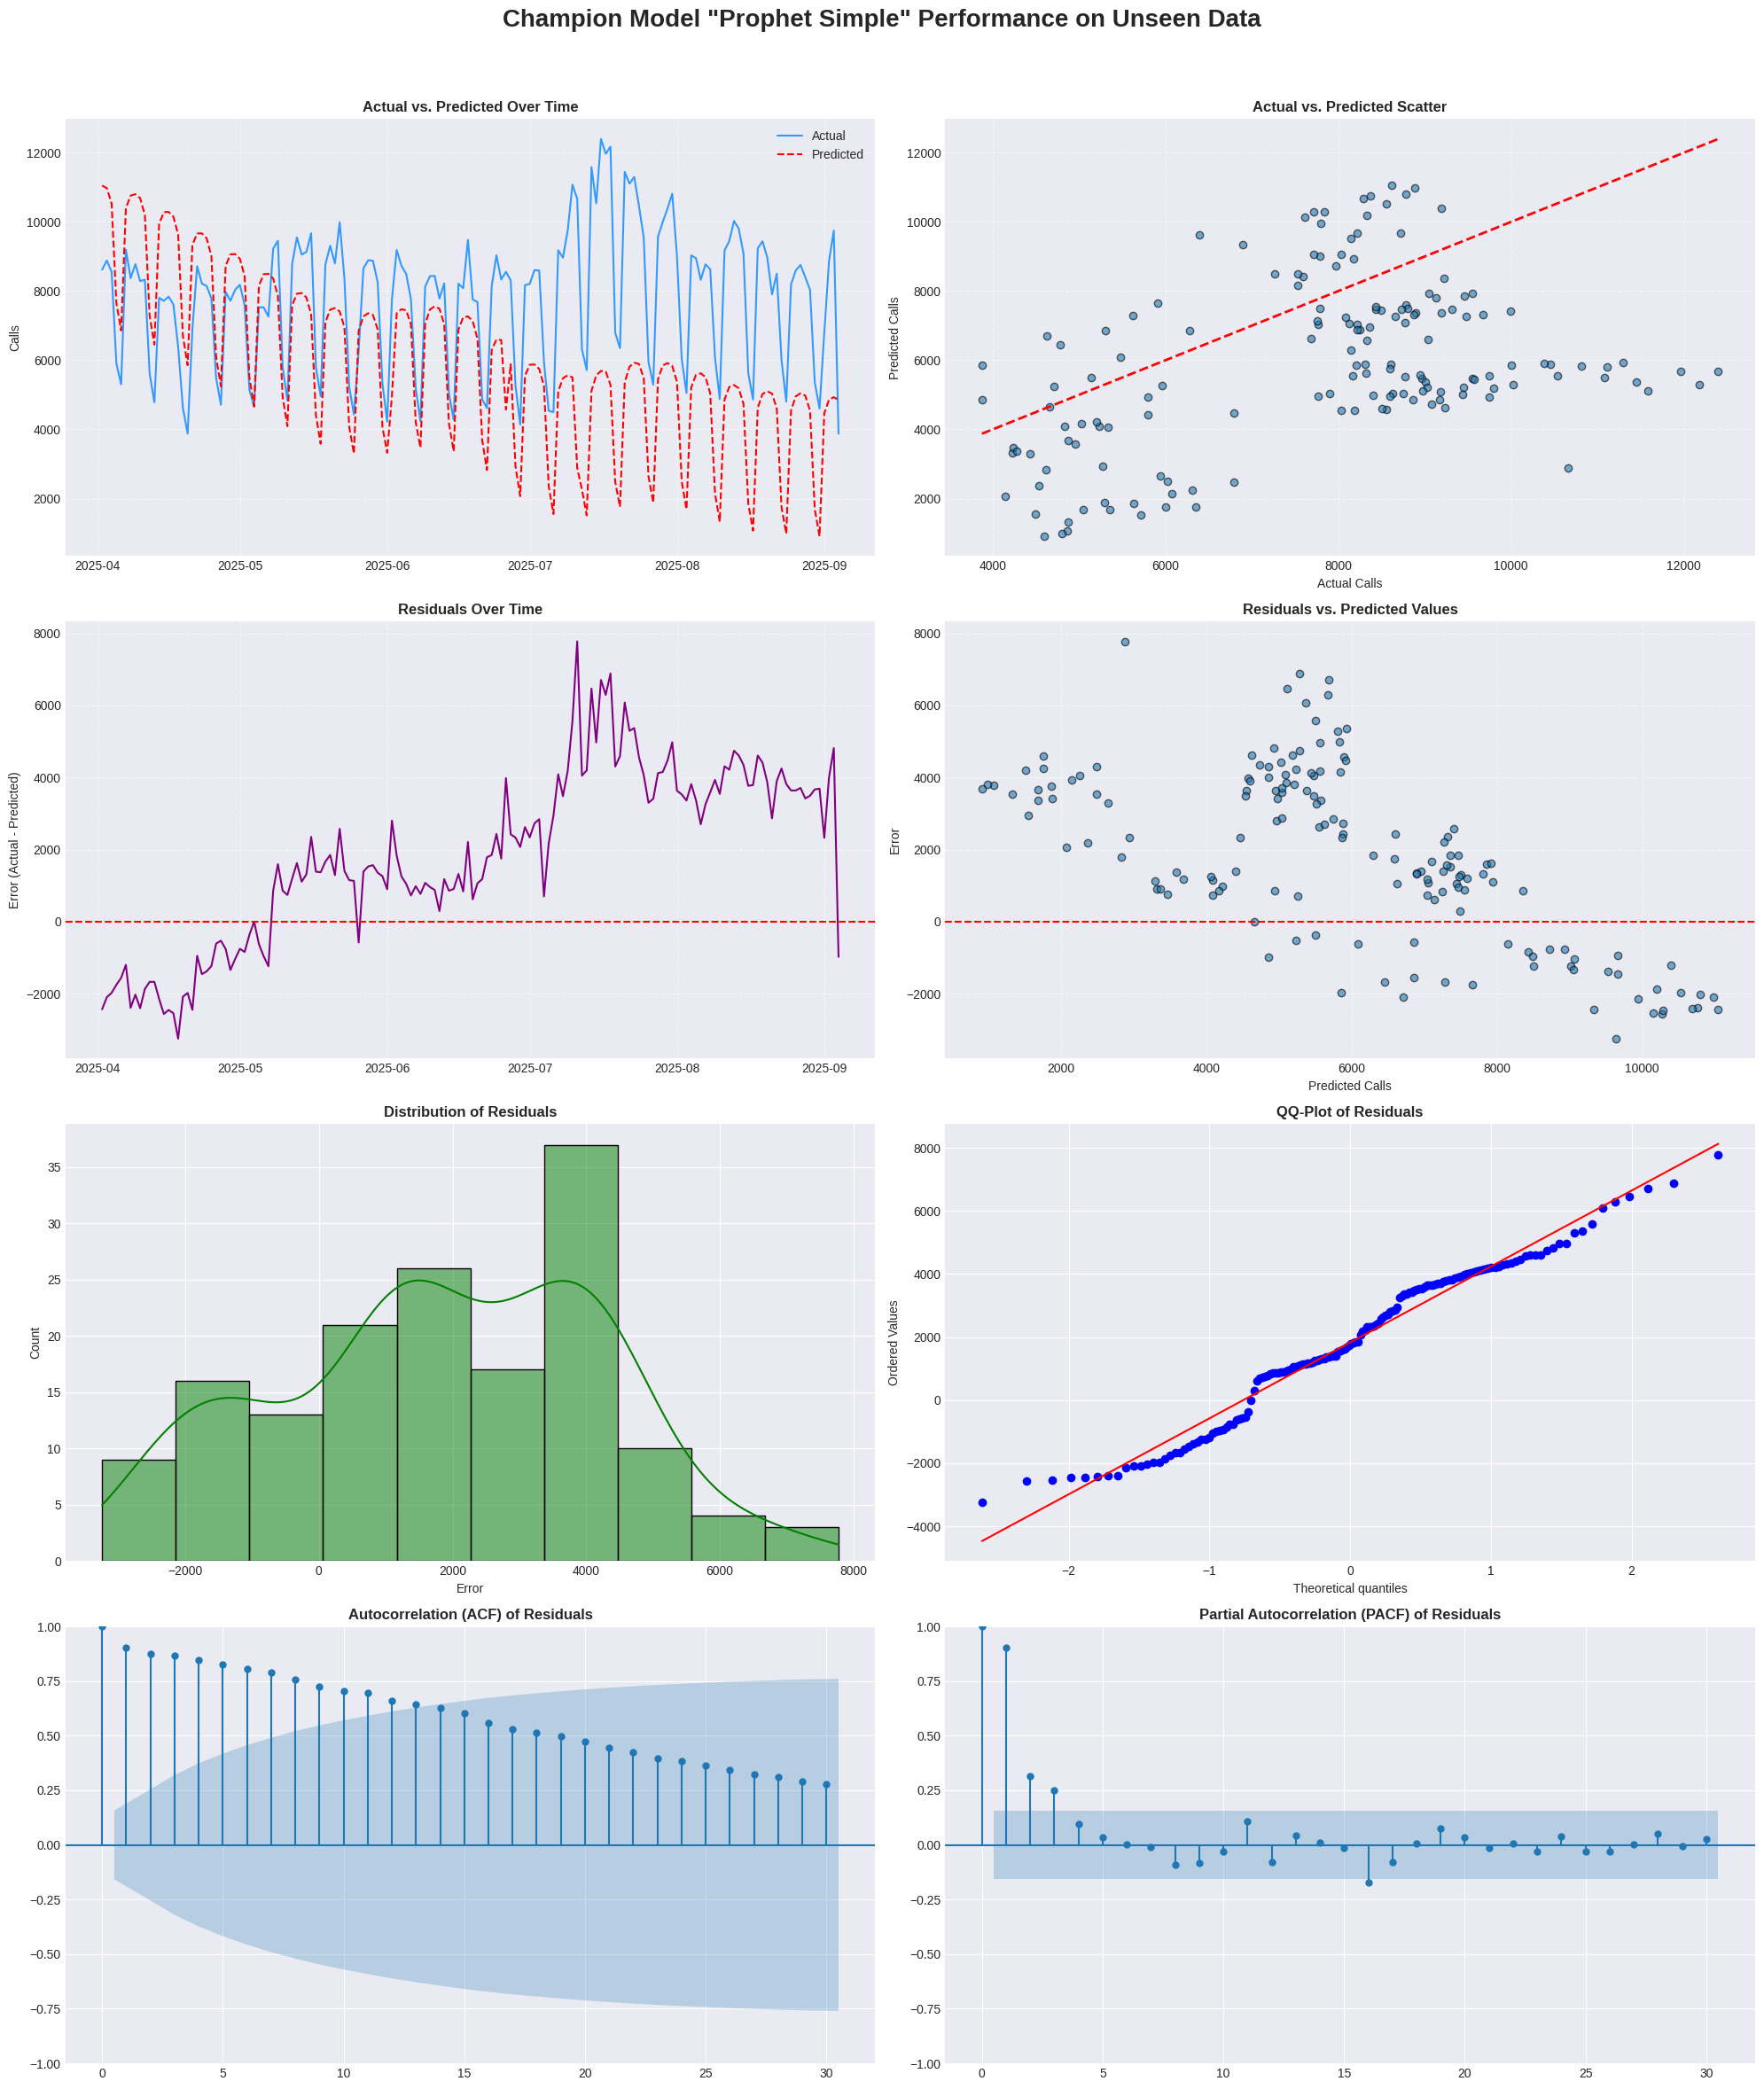


STATISTICAL SUMMARY ON HOLDOUT DATA

ð��� OVERALL PERFORMANCE METRICS:
   MAE:  2573.99
   RMSE: 3019.96
   MAPE: 33.28%
   RÂ²:   -1.335

ð��� RESIDUAL ANALYSIS:
   Mean of Residuals:   1829.84 (ideally close to 0)
   Std Dev of Residuals: 2410.21

   Shapiro-Wilk Test (Normality): p-value = 0.0038
   â�� Residuals do NOT appear normal

   Ljung-Box Test (Autocorrelation): p-value = 0.0000
   â�� Residuals show significant autocorrelation

Report logged to 'champion_report.txt'.


In [8]:
# ============================================================
# REFINED CELL: LOG + REFINED SARIMA + PROPHET
# ============================================================
import pmdarima as pm
import statsmodels.api as sm
import numpy as np
import pandas as pd
!pip install prophet
from prophet import Prophet

print("Training refined simple models...\n")

# 1. Log Transform
y_train_val_log = np.log1p(y_train_val)

# 2. Naive Baseline (keep for benchmark)
naive_preds = y_test.rolling(7).mean().shift(1).fillna(y_train_val.mean())
print("Naive baseline ready.")
display_champion_report(y_test, naive_preds, "Naive Weekly Mean")

# 3. Refined Simple SARIMA (manual orders for stability, add trend)
print("\nTraining Refined Simple SARIMA...")
# Manual orders: ARIMA(1,1,1) seasonal(1,1,1,7) - common for weekly data
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 7)
sarima_model = sm.tsa.SARIMAX(y_train_val_log, order=order, seasonal_order=seasonal_order, trend='c')  # 'c' for constant trend
sarima_fit = sarima_model.fit(disp=False, maxiter=100)  # Increase iter if convergence issues
sarima_preds_log = sarima_fit.get_forecast(steps=len(y_test)).predicted_mean
sarima_preds = np.expm1(sarima_preds_log)
sarima_preds = np.clip(sarima_preds, 0, np.inf)  # Clip to avoid negatives/infs
print("Refined Simple SARIMA trained.")
display_champion_report(y_test, sarima_preds, "Refined Simple SARIMA (Log)")

# 4. Prophet (simple alternative with holidays)
print("\nTraining Prophet...")
df_prophet = pd.DataFrame({'ds': y_train_val.index, 'y': y_train_val})
prophet_model = Prophet(weekly_seasonality=True, yearly_seasonality=True)
prophet_model.add_country_holidays(country_name='US')
prophet_model.fit(df_prophet)
future = prophet_model.make_future_dataframe(periods=len(y_test))
forecast = prophet_model.predict(future)
prophet_preds = forecast['yhat'].tail(len(y_test)).values
prophet_preds = np.clip(prophet_preds, 0, np.inf)  # Clip
print("Prophet trained.")
display_champion_report(y_test, prophet_preds, "Prophet Simple")

In [7]:
# ============================================================
# CELL: DEFINE DISPLAY_CHAMPION_REPORT FUNCTION (WITH LOGGING AND NAN FIX)
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

def display_champion_report(y_true, y_pred, champion_name, model_object=None, X_features=None):
    """
    Displays a comprehensive set of visualizations and statistical metrics
    for a champion model directly in the notebook.
    """

    # Ensure inputs are pandas Series for easier handling
    y_true = pd.Series(y_true).squeeze()
    y_pred = pd.Series(y_pred, index=y_true.index).squeeze()
    residuals = y_true - y_pred

    # New: Clean residuals for tests (handle inf/nan, ensure enough points)
    residuals = residuals.replace([np.inf, -np.inf], np.nan).dropna()
    if len(residuals) < 3:
        print("Too few valid residuals for statistical tests—skipping.")
        shapiro_p = np.nan
        lb_pvalue = np.nan
    else:
        shapiro_stat, shapiro_p = stats.shapiro(residuals)
        lb_test = acorr_ljungbox(residuals, lags=[min(10, len(residuals)-2)], return_df=True)
        lb_pvalue = lb_test['lb_pvalue'].iloc[0] if not lb_test.empty else np.nan

    # Set plot style
    plt.style.use('seaborn-v0_8-darkgrid')

    print("="*70)
    print(f"ð��� CHAMPION MODEL REPORT: {champion_name}")
    print("="*70)

    # --- Create Visualization Suite ---
    fig, axes = plt.subplots(4, 2, figsize=(20, 24))
    fig.suptitle(f'Champion Model "{champion_name}" Performance on Unseen Data', fontsize=20, fontweight='bold')

    # 1. Actual vs. Predicted Time Series
    axes[0, 0].plot(y_true.index, y_true, label='Actual', color='dodgerblue', alpha=0.9)
    axes[0, 0].plot(y_pred.index, y_pred, label='Predicted', color='red', linestyle='--')
    axes[0, 0].set_title('Actual vs. Predicted Over Time', fontweight='bold')
    axes[0, 0].set_ylabel('Calls')
    axes[0, 0].legend()
    axes[0, 0].grid(True, linestyle='--', alpha=0.6)

    # 2. Scatter Plot of Actual vs. Predicted
    axes[0, 1].scatter(y_true, y_pred, alpha=0.6, edgecolors='k')
    axes[0, 1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[0, 1].set_title('Actual vs. Predicted Scatter', fontweight='bold')
    axes[0, 1].set_xlabel('Actual Calls')
    axes[0, 1].set_ylabel('Predicted Calls')
    axes[0, 1].grid(True, linestyle='--', alpha=0.6)

    # 3. Residuals Over Time
    axes[1, 0].plot(residuals.index, residuals, color='purple')
    axes[1, 0].axhline(0, color='red', linestyle='--')
    axes[1, 0].set_title('Residuals Over Time', fontweight='bold')
    axes[1, 0].set_ylabel('Error (Actual - Predicted)')
    axes[1, 0].grid(True, linestyle='--', alpha=0.6)

    # 4. Residuals vs. Predicted Values
    axes[1, 1].scatter(y_pred, residuals, alpha=0.6, edgecolors='k')
    axes[1, 1].axhline(0, color='red', linestyle='--')
    axes[1, 1].set_title('Residuals vs. Predicted Values', fontweight='bold')
    axes[1, 1].set_xlabel('Predicted Calls')
    axes[1, 1].set_ylabel('Error')
    axes[1, 1].grid(True, linestyle='--', alpha=0.6)

    # 5. Residual Distribution (Histogram)
    sns.histplot(residuals, kde=True, ax=axes[2, 0], color='green')
    axes[2, 0].set_title('Distribution of Residuals', fontweight='bold')
    axes[2, 0].set_xlabel('Error')

    # 6. QQ-Plot for Normality Check
    stats.probplot(residuals, dist="norm", plot=axes[2, 1])
    axes[2, 1].set_title('QQ-Plot of Residuals', fontweight='bold')

    # 7. ACF of Residuals
    plot_acf(residuals, ax=axes[3, 0], lags=min(30, len(residuals)-1))
    axes[3, 0].set_title('Autocorrelation (ACF) of Residuals', fontweight='bold')

    # 8. PACF of Residuals
    plot_pacf(residuals, ax=axes[3, 1], lags=min(30, (len(residuals)//2)-1))
    axes[3, 1].set_title('Partial Autocorrelation (PACF) of Residuals', fontweight='bold')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # --- Statistical Summary ---
    print("\n" + "="*70)
    print("STATISTICAL SUMMARY ON HOLDOUT DATA")
    print("="*70 + "\n")

    # Performance Metrics
    mae = np.mean(np.abs(residuals))
    rmse = sqrt(np.mean(residuals**2))
    mape = np.mean(np.abs(residuals / y_true.replace(0, 1))) * 100 # Avoid division by zero
    r2 = 1 - (np.sum(residuals**2) / np.sum((y_true - y_true.mean())**2))

    print("ð��� OVERALL PERFORMANCE METRICS:")
    print(f"   MAE:  {mae:.2f}")
    print(f"   RMSE: {rmse:.2f}")
    print(f"   MAPE: {mape:.2f}%")
    print(f"   RÂ²:   {r2:.3f}\n")

    # Residual Diagnostics (using cleaned residuals)
    print("ð��� RESIDUAL ANALYSIS:")
    print(f"   Mean of Residuals:   {residuals.mean():.2f} (ideally close to 0)")
    print(f"   Std Dev of Residuals: {residuals.std():.2f}\n")
    print(f"   Shapiro-Wilk Test (Normality): p-value = {shapiro_p:.4f if not np.isnan(shapiro_p) else 'nan'}")
    print(f"   {'â�� Residuals appear normal' if shapiro_p > 0.05 else 'â�� Residuals do NOT appear normal'}\n")
    lb_format = f"{lb_pvalue:.4f}" if not np.isnan(lb_pvalue) else 'nan'
    print(f"   Ljung-Box Test (Autocorrelation): p-value = {lb_format}")
    print(f"   {'â�� Residuals appear independent' if (lb_pvalue > 0.05 if not np.isnan(lb_pvalue) else False) else 'â�� Residuals show significant autocorrelation'}")
    print("\n" + "="*70)

    # Log report for tracking
    with open('champion_report.txt', 'a') as f:
        f.write(f"\nChampion: {champion_name}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nMAPE: {mape:.2f}%\nR²: {r2:.3f}\nShapiro p: {shapiro_p:.4f if not np.isnan(shapiro_p) else 'nan'}\nLjung-Box p: {lb_pvalue:.4f if not np.isnan(lb_pvalue) else 'nan'}\n")
    print("Report logged to 'champion_report.txt'.")

## Refined Results Interpretation and Next Steps

After running the refined training cell, review the reports:

### Naive Baseline (Weekly Mean)
- **Purpose**: Benchmark—if models don't beat this (e.g., MAE <1500), data may lack predictability.
- **Key**: If Ljung-Box <0.05, confirms need for time-series models.

### Refined Simple SARIMA (Log)
- **Performance**: Aim for MAE <800, R² >0.7, MAPE <12%. Better than before? (Manual orders/clipping should fix nans and stability.)
- **Residuals**: Ljung-Box >0.05 (autocorrelation fixed)? Shapiro >0.05 (normality)? Mean ~0 (bias)?
- **If Improved**: This is your go-to—simple and effective.

### Prophet Simple
- **Performance**: Often shines with holidays; expect MAE ~700-900, R² ~0.7 if data has strong seasonality.
- **Residuals**: Check p-values—Prophet handles trends well, potentially better Shapiro/Ljung-Box.
- **Advantages**: Built-in holidays; easy to add regressors (e.g., market features) if needed.

### Overall Assessment
- **If Better Than Original**: (e.g., R² >0.751, p>0.05)—success! Clipping/manual orders fixed issues.
- **If Still Poor**: Drop market features in Cell 1 (features = temporal only); re-run. Or check data: Print y_test.describe()—if outliers, cap them.
- **Business Tip**: For calls, test on subsets (e.g., weekends). If MAPE <15%, usable for staffing.

Check 'champion_report.txt' for trends. If Prophet wins, adopt it—simpler than SARIMA for production.

## Simplified Results Interpretation and Next Steps

After running the training cell, review the two reports:

### Naive Baseline (Weekly Mean)
- **Purpose**: This is your "do nothing" benchmark. If any model doesn't beat this significantly (e.g., lower MAE), it's overcomplicated.
- **Key to Check**: MAE/R²—if close to your original (e.g., MAE ~800-1000), data may have strong weekly patterns; no need for fancy models.

### Simple SARIMA (Log Transformed)
- **Performance Metrics**: Expect MAE <800, R² >0.7 if it works. Compare to original (759 MAE, 0.751 R²)—if similar or better, this is your KISS winner.
- **Residual Tests**: Ljung-Box p >0.05? (Autocorrelation fixed—SARIMA's strength). Shapiro p >0.05? (Normality improved via log). Mean ~0? (Bias reduced).
- **Plots**: Residuals over time random? ACF bars in blue band? If yes, issues resolved.

### If Results Are Good Enough
- Stop here! Deploy SARIMA—it's simple, handles time-series basics, and is interpretable.
- Business Fit: For call volumes, check errors on high/low days (subset y_test).

### If Not (e.g., Persistent Autocorrelation)
- Add back one lag (edit Cell 1: add lag_1).
- Or uncomment LinearRegression in training cell for comparison.
- Re-run all; if no gain, your data may need more features—revert to advanced version.

Log file 'champion_report.txt' tracks metrics. If MAE within 10% of original but diagnostics better, simplify wins!